# Introduction to Reinforcement Learning (RL) in PyTorch
### Recap of Supervised Learning

So far, we've primarily concerned ourselves with supervised learning problems (mostly classification).
In supervised learning, we are given some sort of training data consisting of input/output pairs, with the goal being to be able to predict the output given some new inputs after learning the model.
For example, we previously looked at a Convolutional Neural Network (CNN) classification model for MNIST; given a training set of 60000 digit images and corresponding digit labels (e.g. '5'), we learned a model that was capable of predicting the digit label of new MNIST images.
In order words, something like (but not exactly) this:
<img src="media/mnist_cnn_ex.png" alt="mnist_cnn_ex" style="width: 500px;"/>

What if we want to learn how to perform more complex behaviors, where data collection can be expensive? 
How do you teach a robot to walk? 
Self-driving cars? 
How do you defeat human champions in the game of Go? 

### Reinforcement Learning
Enter Reinforcement Learning. 
In Reinforcement Learning, our model (commonly referred to as an *agent* in this context) interacts with an *environment* by taking *actions* $a$ and receives some sort of feedback from the environment in the form of a *reward* $r$. 
In this sense, reinforcement learning algorithms learn by experience.
We call the trajectory of going from start to finish of a task an *episode*, and often our agent will learn by undergoing many episodes.
<img src="media/RL.PNG" alt="RL" style="width: 300px;"/>

Many reinforcement learning algorithms are modeled as Markov Decision Processes (MDPs). 
In these settings, we have a concept of a *state* $s$, which encapsulates the situation of the agent (e.g. location, velocity).
From each state $s_t$, the agent takes an action $a_t$, which results in a transition from one state $s_t$ to another $s_{t+1}$.
In many settings, there is stochasticity in this transition, meaning that there's is a distribution over $s_{t+1}$ conditioned on $s_t$ and $a_t$.
Often, several of these states are considered episode ending, after which the agent can no longer make any transitions or collect any more reward.
These correspond to states such as reaching the final goal, a game concluding, or falling of a cliff.
In the end, our goal is to learn a *policy* $\pi$, or a mapping from states to actions.

In an MDP, we assume that we can always tell which state $s_t$ our agents is in.
However, this isn't always the case.
Sometimes, all we have access to are observations $o_t$ that provide information the state $s_t$, but enough to precisely pinpoint the exact one.
We call such settings Partially Observable Markov Decision Processes (POMDPs).
Imagine for example a [Roomba](https://en.wikipedia.org/wiki/Roomba) being trained to navigate a living room with RL.
From its infrared and mechanical "bump" sensors, it receives partial information ($o_t$) as to where it might be, but not a definitive location ($s_t$).
Operating as a POMDP adds a whole layer of complexity to RL algorithms.
For the rest of day though, we'll focus on MDPs, as their much simpler and easier to use to teach basic concepts.


#### A simple MDP example

<img src="media/MDP.png" alt="MDP" style="width: 400px;"/>


In the above example, we can see the 3 possible states for the agent as $s_0$, $s_1$, and $s_2$, with 2 actions $a_0$ and $a_1$ available from each state.
We can see that the each action doesn't lead to a determinstic transition to the next state, as shown by multiple paths from each action. 
Note that each of the outcomes of an action are labeled with a small black number between 0 and 1.
This denotes the probability of that outcome (which state we end up at) given the the action; as these are probabilites, the sum of the probabilities of arriving at each of the next states $s_{t+1}$ given a previous state $s_t$ and selected action $a_t$ is 1.

#### Objective

The goal of the agent is to maximize the total reward $R$ it can receive over some number of steps.
It is important to ensure the reward actually captures the true goal we want the agent to achieve.
The agent will dutifully attempt maximize the objective it is given, without any considerations to any implicit objectives that a human may desire.
There are more than a few (amusing) anecdotes of RL agents learning undesirable behaviors by exploiting some aspect of the reward function.
As such, defining this reward requires special care.

One countermeasure commonly deployed by RL researchers is the concept of *discounted* rewards.
This is done with a multiplicative term $\gamma$: a reward $T$ steps in the future is discounted as $\gamma^T r_T$.
Using discounting encourages the agent to finish the task sooner rather than later, a common implicit criterion.
With discounting then, the RL agent's goal is to maximize:
\begin{align*}
\mathbb{E}[\sum_{t=0}^{\infty} \gamma^t r_t]
\end{align*}
This is far from the complete solution to making our rewards accurately capture our desired objectives, but achieving higher rewards sooner rather than later is an almost universal preference, so we almost always add it.
Designing a good reward function can be an art is highly dependent on the task.

#### Reinforcement Learning as Supervised Learning?
At first, this doesn't seem too different from the supervised methods we've looked at before, and some natural questions might arise:
- Why can't we just treat RL as a supervised task? 
Why can't we use the reward (or rather, the negative of the reward) as our supervised loss?

Unlike in supervised learning, in reinforcement learning, we often don't have a pre-apportioned dataset to learn from.
In some problems set-ups, we may have examples of other agents (oftentimes humans) performing the desired task, but these aren't necessarily optimal examples of how to maximize the reward, which is what we want to learn.
In most RL settings, we don't have any examples of state-action trajectories beyond what our agent experiences through trial-and-error, which are even more suboptimal.


### Open AI Gym
Before we dive any deeper into implementing reinforcement learning models, first we need an environment.
Remember, the goal is to learn an agent that can interact with an environment in the way we want, so we need something that our agent can interact with and receive rewards from.
In robotics, this is often the real world (or some set-up in the real world).
However, it is oftentimes cheaper and quicker to first test our algorithms in simulated settings.
There are a number of tasks that are popular benchmarks for the reinforcement learning community, such as [cart pole](https://en.wikipedia.org/wiki/Inverted_pendulum), [mountain car](https://en.wikipedia.org/wiki/Mountain_car_problem), or [Atari 2600 games](https://gymnasium.farama.org/environments/atari/). 
In the spirit of accelerating progress and promoting openness in the research community, Open AI has very nicely coded up [Open AI Gym](https://github.com/openai/gym), which has implementations of many of these environments for public use.
We will be using these environments, as it allows us to focus on the algorithms themselves, instead of worrying about implementing each problem setting ourselves.

To use it, we first need to download and install it. Make sure you're in your PyTorch environment first!

See [Gymnasium](https://github.com/Farama-Foundation/Gymnasium), [gym](https://www.gymlibrary.dev/)

```Shell
# If you environment isn't currently active, activate it:
# conda activate pytorch

pip install gym
```

Once it's installed, we can import it like any other Python module:

In [1]:
%matplotlib inline
import gym
import matplotlib.pyplot as plt

Let's start with a simple environment: FrozenLake.
Here's the official description from OpenAI gym:

> *Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.*

A visualization of FrozenLake as a grid world:

<img src="media/FrozenLake.PNG" alt="FrozenLake" style="width: 400px;"/>

At the start of an episode, we begin in the upper left corner (S).
Our goal is to move ourself to the lower right corner (G), avoiding falling into the holes (H).
Icy water is cold.

In reinforcement learning terms, each of the 16 locations on the grid are a state, and an action is attempting to move in one of four directions (left, down, right, up).
Each move will result in the agent's state changing from $s_t$ to $s_{t+1}$ as it changes location, unless it attempts to move in the direction of a wall, which results in the agent's state not changing (the agent doesn't move).
We receive a positive reward of "+1" for reaching the goal (G), discounted according to how long it took.
While there is not a negative reward for falling into a hole (H), the agent still pays a penalty in the sense that falling into the hole is episode-ending and therefore prevents it from receiving any reward. 
We want to learn a policy $\pi$ that takes us from our starting location (S) to the goal (G) in as few steps as possible.

To really establish what we are trying to accomplish here, it's worth debunking a few common initial misconceptions:

- **Knowledge of the states and transition probabilties:** From the top-down view, your first thought might be to plot out a path from the start to the finish, just as you would with a maze.
However, this view is provided to us the algorithm designers so we can visualize the problem at hand.
The agent learning the task does *not* get this prior knowledge; all we are about to tell it is that there are going to be 16 states and 4 possible actions from each state.
A more proper analogy would be if I blindfolded you and dropped you in the middle of a frozen lake, and told you your state (location) every time you decided to take a step in one of four directions, then set off fireworks when you stepped on the frisbee.

- **Knowledge of the goal (reward):** In OpenAI's official description of the environment, you (the agent) know what you're hoping to accomplish: You want to retrieve the frisbee, while avoiding falling through the ice.
The agent does *not* know this.
Rather, it learns the goal by experiencing rewards (or penalties), and the algorithm updates its policy such that it will be more (or less) likely to do those actions again.
Note that this means that if an agent never experiences certain rewards, it won't know they exist.

- **Prior knowledge of pathfinding, physics, etc.:** As a human, even if you haven't solved this task before, you still bring a tremondous amount of prior knowledge to this problem.
For example, you know the shortest path to a destination is a line.
You know that North, South, East, and West, are directions, and that going North and then South brings you back to where you already were.
You know ice is slippery.
You know icy water is cold.
You know being in icy cold water is bad.
It's important to keep in mind that our agent will begin knowing none of these things; it's initial policy is essentially picking actions completely at random.
By the end of the training, it still won't know what abstract concepts like "North/South," "cold," or "slippery" mean, but it will have (hopefully) learned a good policy that allows it to complete the goal.

#### Interacting with FrozenLake
This example is simple enough that we could code the environment and its interface ourselves fairly easily, but OpenAI has already done it, and we'd like to focus on the algorithm of solving it as much as possible.
We can create an instantiation of FrozenLake in a single line of code:

In [2]:
env = gym.make('FrozenLake-v1',render_mode='rgb_array')

Open AI Gym environments provide a mechanism to observe the state of the environment, and since FrozenLake is an MDP (as opposed to POMDP), the observation is the state itself.
For FrozenLake, there are 16 grid locations on the map, meaning we have 16 states.
We can confirm this by looking at the size of the `observation_space` attribute for the environment we just created.

In [3]:
env.observation_space

Discrete(16)

Our agent will interact with this environment causing its state to change.
For FrozenLake, we have 4 options, each corresponding to attempting to step in a particular direction: `[Left, Down, Right, Up]`.
We can confirm this by looking at the size of the `action_space` of our environment.

In [4]:
env.action_space

Discrete(4)

Before interacting with the environment, we have to first reset it to initialize it. 
Resetting also returns an observation of the first state after resetting.
In FrozenLake, we always start in the upper left corner, which corresponds to state 0.
As such, we see the `reset()` command returning `0`.

In [5]:
env.reset()

(0, {'prob': 1})

We can visualize the FrozenLake environment by calling `render()`. 
In more complex tasks this will actually add frames to a video showing our agent's progress, but for FrozenLake, it just prints out a text representation, with the highlighted character showing our agent's current location.
We can see that we started in the upper-left corner, on the "S," as promised.

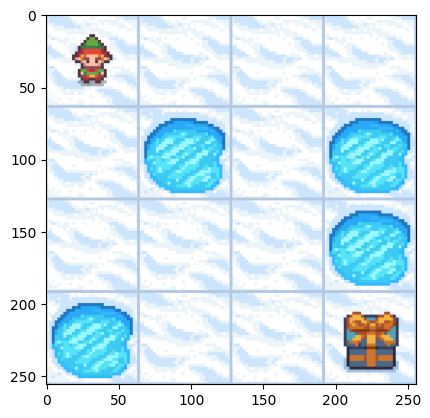

In [6]:
plt.imshow(env.render())